# Scaling up to $n$ emitters

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter, ControlledGate, Gate, ParameterVector
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RYGate
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

n = 6
initial_state = [0]*(2**n)
initial_state[-1] = 1

system = QuantumRegister(n, name = 'q')
environment = QuantumRegister(n, name = 'e')

tilde_alpha = ParameterVector('$\\tilde{\\alpha} (\\tilde{g})$', n-1)
tilde_beta = ParameterVector('$\\tilde{\\beta} (\\tilde{\\omega})$', n)
theta_plus = ParameterVector('$\\theta_{+} $', n-1)
theta_minus = ParameterVector('$\\theta- $', n-1)

# Initialization

init = QuantumCircuit(system, environment)
initial_statevector = Statevector(initial_state) 
init.initialize(params = initial_statevector, qubits = system, normalize = True)

init.barrier()

# Free evolution

u_0 = QuantumCircuit(system, environment)

for i in range(n):

    u_0.rz(tilde_beta[i], system[i])

u_0.barrier()

# Interaction layer

u1 = QuantumCircuit(system, environment)

for j in range(0, n-1, 2):

    u1.ryy(tilde_alpha[j], qubit1 = system[j], qubit2 = system[j+1])
    u1.rxx(tilde_alpha[j], qubit1 = system[j], qubit2 = system[j+1])

if n > 2:

    u2 = QuantumCircuit(system, environment)

    for k in range(1, n-1, 2):

        u2.ryy(tilde_alpha[k], qubit1 = system[k], qubit2 = system[k+1])
        u2.rxx(tilde_alpha[k], qubit1 = system[k], qubit2 = system[k+1])

    u_int = u1.compose(u2)

else:

    u_int = u1

u_int.barrier()

# Decay

u_decay = QuantumCircuit(system, environment)

u_decay_first_layer = QuantumCircuit(system, environment)

P_gate = Gate(name = 'P', params = [],num_qubits = 2, label = '$P$')

P_dag_gate = Gate(name = 'Pdag', params = [], num_qubits = 2, label = '$P^{\\dag}$')

#ccry_plus = ControlledGate(name = 'ryplus', num_qubits = 3, params = [theta_plus[j] - theta_minus[j]], num_ctrl_qubits= 2, base_gate = RYGate(theta_plus - theta_minus))

#ccry_minus = ControlledGate(name = 'ryminus', num_qubits = 3, params = [theta_minus[j] - theta_plus[j]], num_ctrl_qubits= 2, base_gate = RYGate(theta_minus - theta_plus))

for j in range(0, n-1, 2):

        u_decay_first_layer.append(P_gate, [system[j], system[j+1]])

        ccry_plus = RYGate(theta_plus[j] - theta_minus[j]).control(2)

        ccry_minus = RYGate(theta_minus[j] - theta_plus[j]).control(2)

        u_decay_first_layer.append(ccry_plus, [system[j], system[j+1], environment[j]])

        u_decay_first_layer.append(ccry_minus, [system[j], system[j+1], environment[j+1]])

        u_decay_first_layer.cry(theta_minus[j], system[j], environment[j])

        u_decay_first_layer.cry(theta_plus[j], system[j+1], environment[j+1])

        u_decay_first_layer.cx(environment[j], system[j])

        u_decay_first_layer.cx(environment[j+1], system[j+1])

        u_decay_first_layer.append(P_dag_gate, [system[j], system[j+1]])

        u_decay_first_layer.reset([environment[j], environment[j+1]])
    
    # And onto the second layer
u_decay_first_layer.barrier()

if n > 2:

    u_decay_second_layer = QuantumCircuit(system, environment)

    for j in range(1, n-1, 2):

        u_decay_first_layer.append(P_gate, [system[j], system[j+1]])

        ccry_plus = RYGate(theta_plus[j] - theta_minus[j]).control(2)

        ccry_minus = RYGate(theta_minus[j] - theta_plus[j]).control(2)

        u_decay_second_layer.append(ccry_plus, [system[j], system[j+1], environment[j]])

        u_decay_second_layer.append(ccry_minus, [system[j], system[j+1], environment[j+1]])

        u_decay_second_layer.cry(theta_minus[j], system[j], environment[j])

        u_decay_second_layer.cry(theta_plus[j], system[j+1], environment[j+1])

        u_decay_second_layer.cx(environment[j], system[j])

        u_decay_second_layer.cx(environment[j+1], system[j+1])

        u_decay_second_layer.append(P_dag_gate, [system[j], system[j+1]])

        u_decay_second_layer.reset([environment[j], environment[j+1]])

    u_decay = u_decay_first_layer.compose(u_decay_second_layer)

else:

    u_decay = u_decay_first_layer

u_decay.barrier()

u = init.compose(u_0).compose(u_int).compose(u_decay)

a = u.draw('mpl', fold = 70)
a.savefig('circuit for 6 qubits')
a

In [ ]:
from merge_methods_CHAIN import solve_master_equation
from efficient_qiskit_solver_markovian_CHAIN import markovian_qiskit_solver
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt


#n = 3

omega_c = 1.1

#g = [0.001, 0.004]

kappa = [0.2]


t = np.linspace(0, 750, 150)

r = 5
backend = AerSimulator()
optimization_level = 0
options = {'resilience_level' : 1,
           'default_shots' : 10**3,
           'optimization_level' : 1}

#n_molecules = [2,3,5,7]#,10]

n_molecules = [2]

qc_populations = {}
qutip_populations = {}

for i in n_molecules:

    omega_m = [1.1]*i
    #omega_m = [1.1, 1.1]
    g = [0.02, 0.01]
    #g = [0.01]*(2*(i-1))
    gamma = [0.8*(10**-6)]*i
    initial_state = [0]*(2**i)
    initial_state[-1] = 1

    evs_markov = solve_master_equation(i, omega_m, omega_c, gamma, kappa, g, t, initial_state, 'markovian')
    print('markovian computed')
    #evs_original = solve_master_equation(n, omega_m, omega_c, gamma, kappa, g, t, initial_state, 'original')
    #print('original computed')
    evs_qc = markovian_qiskit_solver(i, omega_m, omega_c, gamma, g, kappa, t, r, initial_state, backend, optimization_level, options)
    print('qiskit computed')

    qc_populations['n = %s' %i] = evs_qc

    qutip_populations['n = %s' %i] = evs_markov

    print('n = %s finished!' %i)

    #labels = ['0', '1']

#np.savez('qc_populations', qc_populations)
#np.savez('markovian_populations', qutip_populations)

#for l in labels:

    #plt.plot(t, evs_original[l], label = 'full %s' %l)

    #plt.plot(t, evs_markov[l], linestyle = 'dashed', label = 'Markov %s' %l)
    #plt.plot(t, evs_qc[l], linestyle = 'dashed', label = 'Qiskit')

#plt.plot(t, evs_markovian['E'] + evs_markovian['+'] + evs_diagonal['G'])

#plt.yscale('log')
#plt.xscale('log')
#plt.ylabel('population')
#plt.xlabel('time')
#plt.legend()
#plt.show()

markovian computed


c:\Users\Benjamin\AppData\Local\Programs\Python\Python312\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")
c:\Users\Benjamin\AppData\Local\Programs\Python\Python312\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:234: UserWarning: Options {'transpilation': {'optimization_level': 1}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


qiskit computed
n = 2 finished!


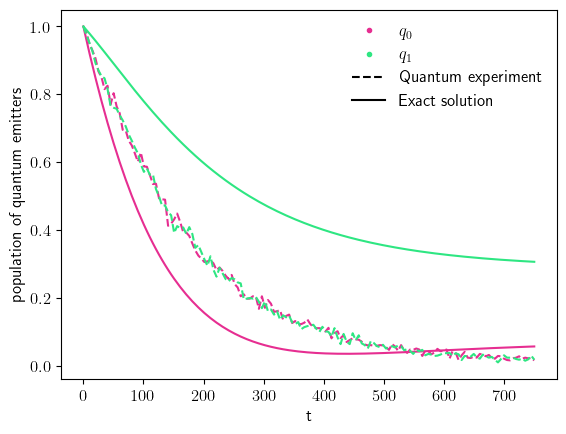

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import colorsys
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600
plt.rcParams.update({'font.size': 12})
from generate_complementary_colors import generate_complementary_colors

#qc_data = np.load('qc_populations.npz', allow_pickle = True)
#qutip_data = np.load('markovian_populations.npz', allow_pickle = True)

#qc_pops = qc_data['arr_0'].item()
#qutip_pops = qutip_data['arr_0'].item()

qc_pops = qc_populations
qutip_pops = qutip_populations

#t = np.linspace(0, 750, 250)

plot_qubits = ['0','1']

for key in qc_pops:

    #for qubit in qc_pops[key].keys():

    for qubit in plot_qubits:

        colors = generate_complementary_colors(len(qc_pops[key].keys()), palette_type = 'default', start_color = 'deeppink')

        plt.plot(t, qutip_pops[key][qubit], color = colors[int(qubit)])
        plt.plot(t, qc_pops[key][qubit], color = colors[int(qubit)], linestyle = 'dashed')
        plt.plot(np.NaN, np.NaN, linestyle = 'None', marker = '.', color =  colors[int(qubit)], label = '$q_{%i}$' %int(qubit))

    plt.plot(np.NaN, np.NaN, linestyle = 'dashed', color = 'black', label = 'Quantum experiment')
    plt.plot(np.NaN, np.NaN, linestyle = 'solid', color = 'black', label = 'Exact solution')
    plt.xlabel('t')
    plt.ylabel('population of quantum emitters')
    #plt.yscale('log')
    #plt.title(key)
    plt.legend(frameon=False)
    #plt.savefig('markovian circuit for %s' %key)
    #plt.savefig('weak coupling n emitters', bbox_inches='tight')
    plt.show()
